# Creating a gold standard from existing Taboo cards

## Reading in and formatting the cards

The Taboo cards that our gold standard will be based on belong to Elizabeth's Canadian edition of Taboo, produced sometime in the 1990s or early 2000s.

In [26]:
FILENAME = "taboo_cards.txt"


def read_in(filename):
    """
    Reads in transcribed Taboo card words contained in the given file and returns them in an enumerated list.
    """
    file_lines = []
    
    with open(filename, "r", encoding='utf-8') as myfile:
        
        # Go through every line, saving non-empty ones to the list file_lines.
        for line in myfile:
            if line.strip() != '':             
                file_lines.append(line.strip()) 
                
    return list(enumerate(file_lines))
    
            
def format_cards(enum_list):
    """
    Given an enumerated list (output of read_in()), formats the contents as a dictionary (key = MW, values = list of TWs)
    """
    
    # Initialise dictionary to contain card data.
    card_dict = dict()
    
    # Assign MWs (every sixth word in the enumerated list) as dictionary keys, and create a list for the dict's
    # value consisting of the five following words (the TWs); the word[1:] removes the dash from the beginning of
    # each TW's string.

    for enum, wd in enum_list:
        if enum % 6 == 0:
            card_dict[wd] = [word[1:] for num, word in enum_list[enum+1:enum+6]]
        
    return card_dict
        

enum_lines = read_in(FILENAME)
cards = format_cards(enum_lines)

In [27]:
# Example: the five TWs from the MW 'syrup'
cards['syrup']

['maple', 'pancakes', 'trees', 'sap', 'sweet']

In [28]:
len(cards)

240

In addition to this dictionary format, it will be helpful to set up a pandas dataframe for easy addition of columns for semantic similarity and corpus-based collocation measures below.

In [29]:
import pandas as pd
import numpy as np

In [30]:
# Create a pandas dataframe quickly based on a list of dictionaries, with each dictionary corresponding to a row in the 
# dataframe.
# ( Source: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/17496530#17496530 )

rows_list = []

for mainwd, tabwds in cards.items():
    for tabwd in tabwds:
        
        # Create a dictionary for each row of the dataframe (key = column name, value = row value for that column)
        row = {
            'mw': mainwd,
            'tw': tabwd
        }
        
        # Append to rows_list, and use that list as a basis for the new dataframe.
        rows_list.append(row)

data = pd.DataFrame(rows_list)
data.head()

,mw,tw
0,huddle,gather
1,huddle,football
2,huddle,group
3,huddle,play
4,huddle,together


In [31]:
# Export dataframe to csv for manual annotation
#data.to_csv(r'gold-std-raw.csv', index=False, encoding='utf-8')

In [32]:
# After manual annotation, read the csv back in and save as pandas dataframe, replacing NaNs with 0.
GS_CSV_FILE = 'gold-std-categorised.csv'

gs_df = pd.read_csv(GS_CSV_FILE, encoding='utf-8')
gs_df.fillna(0,inplace=True)
gs_df.head()

,mw,tw,semrel_synonym,semrel_antonym,semrel_hyponym,semrel_hypernym,collocation,cultural_ref,other
0,huddle,gather,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,huddle,football,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,huddle,group,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,huddle,play,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,huddle,together,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Count and plot the number of categories appearing in the dataset

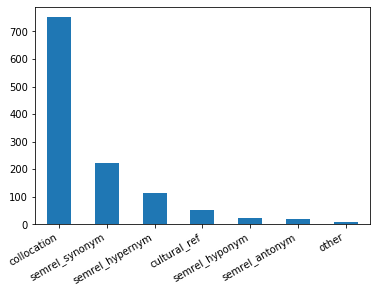

In [49]:
# Get the sum of each column as a series.
gs_df_sum = gs_df.loc[:, 'semrel_synonym':'other'].sum()
gs_df_sum.sort_values(ascending=False, inplace=True)

# Create a bar plot object out of it.
# (Plot y axis labels as integers by creating a list of integers based on the y range)
yint = [x for x in range( int(gs_df_sum.max()) + 1 )]
gs_df_sum_plot = gs_df_sum.plot.bar(x='category', y='count')

# For readable x axis tick labels, set their rotation angle to 30 and the horizontal alignment to right.
gs_df_sum_plot.set_xticklabels(gs_df_sum_plot.get_xticklabels(), rotation=30, horizontalalignment='right');

In [50]:
# To save the figure, convert to a "figure" object and then export as pdf
fig = gs_df_sum_plot.get_figure()
fig.savefig('freq_plot.pdf', bbox_inches='tight')

### Convert this frequency distribution to a probability distribution
- associate each label with a given weight, based on its frequency
- RV: semrel
- values of semrel: the categories above (that we  care about -- ignore "cultural_ref" and "other")
- return dict w labels and weights

In [ ]:
# Before converting to a probability distribution, remove the categories we aren't interested in ("cultural_ref" and "other").
gs_df_sum.drop(labels=['cultural_ref', 'other'], inplace=True)

In [61]:
# Convert the frequency distribution to a probability distribution by dividing by the sum of all observations
prob_dist = gs_df_sum / gs_df_sum.sum()
prob_dist

collocation        0.663428
semrel_synonym     0.196996
semrel_hypernym    0.101590
semrel_hyponym     0.020318
semrel_antonym     0.017668
dtype: float64

In [118]:
pd = dict(prob_dist)


def select_one_category(prob_dist_dict):
    """
    Given a probability distribution of semantic relation labels, randomly returns one of them, weighted by probability.
    
    Arg:
        prob_dist_dict: a dictionary with semantic relation labels as keys and their probability as values.
    Returns:
        A string corresponding to one semantic relation label.
    """
    # For clarity, save keys as labels and values as probabilities.
    labels = list( prob_dist_dict.keys() )
    probs = list( prob_dist_dict.values() )
    
    # Use numpy's .choice() to return a label based on the given weight.
    return np.random.choice(labels, p=probs) 


def select_five_categories(prob_dist_dict):
    """
    Given a probability distribution of semantic relation labels, randomly returns a list of five of them, weighted 
    by probability.
    
    Arg:
        prob_dist_dict: a dictionary with semantic relation labels as keys and their probability as values.
    Returns:
        A list containing five semantic relation labels (intended as the starting point for each card).
    """
    # For clarity, save keys as labels and values as probabilities.
    labels = list( prob_dist_dict.keys() )
    probs = list( prob_dist_dict.values() )
    
    # Use numpy's .choice() to return a label based on the given weight.
    return list( np.random.choice(labels, 5, p=probs) )


select_five_categories(pd)

['semrel_synonym',
 'collocation',
 'semrel_hypernym',
 'collocation',
 'collocation']

In [70]:
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
list( np.random.choice(aa_milne_arr, 5, p=[0.5, 0.1, 0.1, 0.3]) )

['pooh', 'Christopher', 'pooh', 'Christopher', 'pooh']

## Computing semantic similarity with gensim

In [34]:
import gensim

# The following line of code requires that the large word embeddings file is in the current directory (not set up on
# GitHub because it is too large to push around nicely, so for replication, have to add this file manually).
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [151]:
sim = model.most_similar('flower')
sim

[('floral', 0.7493643760681152),
 ('flowers', 0.7488502264022827),
 ('roses', 0.697738766670227),
 ('orchid', 0.6928980350494385),
 ('tulip', 0.6629416346549988),
 ('peony', 0.6613221764564514),
 ('blooms', 0.6554170250892639),
 ('blossoms', 0.6527379751205444),
 ('chrysanthemum', 0.6500308513641357),
 ('anthurium', 0.6497662663459778)]

In [144]:
for tup in sim:
    if 'cat' not in tup[0]:
        print(tup[0])

dog
kitten
feline
beagle
puppy
pup
pet
felines
chihuahua


In [145]:
[tup[0] for tup in sim if 'cat' not in tup[0]]

['dog',
 'kitten',
 'feline',
 'beagle',
 'puppy',
 'pup',
 'pet',
 'felines',
 'chihuahua']

In [279]:
from nltk.stem import WordNetLemmatizer 

def get_collocations(word, forbidden_wds, gensim_model, num_collocates, num_to_check = 10):
    """
    Returns minimum num_collocates most similar words to the given word based on gensim word embeddings.
    
    Arg:
        word: A string representing the main word.
        forbidden_wds: A set containing words as strings that may not be included as output.
        gensim_model: The pre-trained word embeddings.
        num_collocates: An integer, the number of collocates to generate.
        num_to_check: (default 10) the number of most similar words to begin with.
    Returns:
        A list of collocated words as strings.
    """
    
    lemmatizer = WordNetLemmatizer() 
    
    # Use gensim's most_similar() function to get the (initially ten) words whose embeddings are most similar to the
    # input word's. Lemmatise the words to remove plural/other inflections.
    similar_tups = gensim_model.most_similar(word, topn=num_to_check)
    similar_wds = [lemmatizer.lemmatize( tup[0] ) for tup in similar_tups]
    
    # Now save those words that do not contain the input word.
    filtered = [wd for wd in similar_wds if (word not in wd.lower() and wd not in forbidden_wds)]
    filtered = set(filtered)
    
    # Recursive bit: Check if there are at least num_collocates different words in filtered (base case).
    # If not, increase the number of words to check in each recursive iteration by three and run the function again. 
    # Will stop once there are minimum num_collocates words in filtered.
    
    if len(filtered) >= num_collocates:
        return filtered
    else:
        num_to_check += 3
        return get_collocations(word, forbidden_wds, gensim_model, num_collocates, num_to_check)
        

get_collocations('pig', {'chicken', 'pup'}, model, num_collocates=4)

{'bovine', 'cow', 'goat', 'hog', 'rabbit', 'swine'}

## WordNet semantic relations

This bit worked well! Using WordNet, I created dictionaries for a given input word that contain all of that word's synonyms, antonyms, hypernyms, and hyponyms :) 

In [16]:
from nltk.corpus import wordnet as wn

In [333]:
def word_to_synsets(word):
    """
    Converts the given word to a synset object.
    
    Arg:
        word: a string like 'cat'
        pos: the desired part of speech (choices: wn.NOUN, wn.VERB, wn.ADJ, wn.ADV)
    Returns:
        A string containing the first synset ID, formatted according to WordNet's conventions, e.g. 'cat.n.01',
        corresponding to that word.
    """
    # Convert word string to the synset with the corresponding part of speech.
    return wn.synsets(word)
    

def synset_to_word(synset):
    """
    Converts the given synset to the actual word it represents.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A string containing the word corresponding to that synset.
    """   
    # Convert synset to lemma, since this is what name() is defined over.
    return synset.lemmas()[0].name()


def get_antonyms(synset):
    """
    Returns all antonyms for the given synset.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of antonymic words as strings, if there are any, or else the empty list.
    """    
    # Convert synset to lemma, since this is what the antonym relation is defined over, and get antonym(s).
    ant_lemmas = synset.lemmas()[0].antonyms()
    
    # Convert each antonym in this list to a string and return list (empty if no antonyms).
    return [ant_lemma.name() for ant_lemma in ant_lemmas]


def get_hypernyms(synset):
    """
    Returns all immediate hypernyms for the given synset.
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hypernymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hyper) for hyper in synset.hypernyms()]


def get_hyponyms(synset):
    """
    Returns all immediate hyponyms for the given synset. (There are often many.)
    
    Arg:
        synset: a WordNet Synset object
    Returns:
        A list of hyponymic words as strings.
    """
    # Convert hypernyms of the synset to strings and return list.
    return [synset_to_word(hypo) for hypo in synset.hyponyms()]


def get_synonyms(word):
    """
    Returns a set of synonyms, according to WordNet, for the given input word (using all of its senses, if
    there are multiple).
    
    Arg:
        word: a string representing the word whose synonyms we want.
    Returns:
        A set containing all of the other words in the same WordNet synset as the given word.
    """
    # Initialise set that will collect the synonyms.
    synonym_set = set()
    
    # Convert the word to a list of synsets.
    synset_list = word_to_synsets(word)

    # Get all the lemmas corresponding to the given word's synset.
    synonym_lems = [x.lemmas() for x in synset_list]
    
    # Go through them, get the names from the lemma (lowercasing everything for consistency), and add
    # to synonym_set.
    for lemma_list in synonym_lems:
        syn = lemma_list[0].name().lower()
        synonym_set.update( [syn] )

    # Remove from the synonym set the input word and any words that also contain the input word and return.
    to_rm = set()
    for synonym in synonym_set:
        if synonym == word or word in synonym:
            to_rm.update({synonym})

    return synonym_set.difference(to_rm)


def make_semrel_dict(word):
    """
    Creates a dictionary that contains all words standing in the given semantic relation to the main word.
    
    Arg:
        gensim_model: -----
        word: a string like 'cat' (the main word)
    Returns:
        A dictionary with the semantic relations as keys and a set of words that have that relation to all senses
        of the input word, according to WordNet, as values.
    """
    
    # Initialise dictionary (and we can get synonyms right away).
    semrel_dict = {
        'semrel_synonym': get_synonyms(word),
        'semrel_antonym': set(),
        'semrel_hypernym': set(),
        'semrel_hyponym': set()
    }
    
    # Convert the input word to all of its synsets.
    ss = word_to_synsets(word)
    
    # Go through each synset, determining its antonyms, hypernyms, and hyponyms, and adding each to the set in the
    # appropriate entry of the dictionary, as long as the main word does not appear as part of any of those strings.
    for s in ss:
        semrel_dict['semrel_antonym'].update( [w for w in get_antonyms(s) if word not in w] )
        semrel_dict['semrel_hypernym'].update( [w for w in get_hypernyms(s) if word not in w] )
        semrel_dict['semrel_hyponym'].update( [w for w in get_hyponyms(s) if word not in w] )
        
    return semrel_dict

In [334]:
make_semrel_dict('bad')

{'semrel_synonym': {'regretful'},
 'semrel_antonym': {'good', 'unregretful'},
 'semrel_hypernym': {'quality'},
 'semrel_hyponym': {'evil',
  'inadvisability',
  'liability',
  'undesirability',
  'unsoundness',
  'unworthiness',
  'worse'}}

# The real deal

In [437]:
import random as rd


def card_generator(mw, gensim_model, prob_dist_dict):
    """
    the big boi
    """
    tws = set()
    
    # Generate five categories with the weighted probabilities based on their frequency in the gold standard data.
#     five_semrels_list = select_five_categories(prob_dist_dict)  # from gspd
#     five_semrels = pd.Series(five_semrels_list)
    five_semrels = pd.Series(['collocation', 'collocation', 'collocation', 'semrel_synonym', 'semrel_synonym'])
#     print(five_semrels)
    
    # Count the number of instances of each semrel category in that list.
    semrels_counts = five_semrels.value_counts()
    print('\n',semrels_counts)
    
    # Generate the semantic relations dictionary.
    srdict = make_semrel_dict(mw)  # from sr
    print('\n', srdict)
    print()
    
    # For each category chosen for the given card, choose one word uniformly at random from the appropriate set.
    # If the choice cannot be made (the set is empty or there aren't enough elements in it), then add the label 
    # to error_labels to keep track of.
    
    # RESUME: There has to be a smarter way to do this.
    
    error_labels = []
    for label, count in semrels_counts.items():
        
        # For semrel labels (not collocations)
        if label != 'collocation':
            try:
                # Add word to the TWs set.
                tws.update( rd.sample( tuple( srdict[label] ), count ) )
            except ValueError:
                error_labels.append(label)
    
    # For each label in error_labels, generate a different category with select_one_category().
    for label in error_labels:
        newlabel = select_one_category(prob_dist_dict) # from gspd

    
    # Once all the semrel labels are filled, generate as many collocations as are left over. (5 - len(tws))
    
    # Add those to the set.
    
    # Return as a dictionary with the MW as the key and the five TWs as elements of the list in the value.
    print()
    print('Error labels:', error_labels)
    print()
    print('TWs:', tws)
    
probdist = dict(prob_dist)

card_generator('evil', model, probdist)


 collocation       3
semrel_synonym    2
dtype: int64

 {'semrel_synonym': {'malefic'}, 'semrel_antonym': {'good'}, 'semrel_hypernym': {'transgression', 'immorality', 'bad'}, 'semrel_hyponym': {'nefariousness', 'worst', 'malevolence', 'malignity', 'reprehensibility', 'perversity', 'sexual_immorality', 'Four_Horsemen', 'maleficence', 'error', 'frailty', 'irreverence', 'villainy', 'foul_play'}}


Error labels: ['semrel_synonym']

TWs: set()
